In [1]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

#for evaluation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

#for modeling
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Bidirectional, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

np.random.seed(123)

## Load data

In [2]:
df = DataReader('LUV', data_source='yahoo', start='2012-01-01', end=datetime.now())

In [3]:
data = df.filter(['Close'])

In [4]:
dataset = data.values

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [6]:
training_data_len = int(np.ceil( len(dataset) * .9 ))
train_data = scaled_data[0:int(training_data_len), :]

In [7]:
train_data.shape

(2195, 1)

## Data preparation

In [8]:
def train_val(data):
    train_size = int(len(data) * 0.8)
    train = data[0:train_size]
    val= data[train_size:len(data)]
    return train, val

In [9]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
def prepare_training(data, n_steps_in, n_steps_out):
    #data = to_dataset(data)
    train, val = train_val(data)
    x_train, y_train = split_sequences(train, n_steps_in, n_steps_out)
    x_val, y_val = split_sequences(val, n_steps_in, n_steps_out)
    features = 1
    return x_train, y_train, x_val, y_val, features

In [11]:
n_steps_in, n_steps_out = 60 , 30
x_train, y_train, x_val, y_val, feature = prepare_training(train_data,n_steps_in, n_steps_out)

In [12]:
x_train.shape

(1667, 60, 1)

In [13]:
y_train.shape

(1667, 30)

## Modeling

In [14]:
def creat_model1(n_steps_in, n_steps_out, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(n_steps_in, features)))
    model.add(RepeatVector(n_steps_out))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(features))
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [15]:
# define model
def creat_model2(n_steps_in, n_steps_out, features):
    model2 = Sequential()
    model2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, features)))
    model2.add(LSTM(50, activation='relu'))
    model2.add(Dense(n_steps_out))
    model2.add(Activation('linear'))
    
    model2.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])
    
    return model2

In [16]:
#Stop training when a monitored metric has stopped improving.
early = EarlyStopping(monitor='val_loss',patience=5)

#Reduce learning rate when a metric has stopped improving.
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

opt = optimizers.Adam(learning_rate=0.0001)

In [17]:
model1 = creat_model1(n_steps_in, n_steps_out, feature)

In [18]:
model2 = creat_model2(n_steps_in, n_steps_out, feature)

In [19]:
history2 = model2.fit(x_train, y_train, epochs=60 , steps_per_epoch=25, verbose=1,
         validation_data=(x_val, y_val))

Epoch 1/60
25/25 [==============================] - 3s 67ms/step - loss: 0.3323 - mean_squared_error: 0.3323 - val_loss: 0.4518 - val_mean_squared_error: 0.4518
Epoch 2/60
25/25 [==============================] - 1s 48ms/step - loss: 0.3202 - mean_squared_error: 0.3202 - val_loss: 0.4333 - val_mean_squared_error: 0.4333
Epoch 3/60
25/25 [==============================] - 1s 48ms/step - loss: 0.3057 - mean_squared_error: 0.3057 - val_loss: 0.4073 - val_mean_squared_error: 0.4073
Epoch 4/60
25/25 [==============================] - 1s 48ms/step - loss: 0.2801 - mean_squared_error: 0.2801 - val_loss: 0.3527 - val_mean_squared_error: 0.3527
Epoch 5/60
25/25 [==============================] - 1s 48ms/step - loss: 0.2286 - mean_squared_error: 0.2286 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 6/60
25/25 [==============================] - 1s 48ms/step - loss: 0.1587 - mean_squared_error: 0.1587 - val_loss: 0.1787 - val_mean_squared_error: 0.1787
Epoch 7/60
25/25 [================

In [20]:
history1 = model1.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1,
         validation_data=(x_val, y_val), callbacks=[early,reduce])

Epoch 1/50
34/34 [==============================] - 4s 77ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 2/50
34/34 [==============================] - 2s 73ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 3/50
34/34 [==============================] - 2s 73ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 4/50
34/34 [==============================] - 2s 73ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 5/50
34/34 [==============================] - 2s 73ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 6/50
34/34 [==============================] - 2s 73ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 7/50
34/34 [================

In [21]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


In [22]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
activation (Activation)      (None, 30)                0         
Total params: 32,130
Trainable params: 32,130
Non-trainable params: 0
_________________________________________________________________


## Test data set

In [23]:
test_data = scaled_data[training_data_len: , :]
x_test, y_test = split_sequences(test_data, n_steps_in, n_steps_out)

In [24]:
test_data.shape

(243, 1)

In [25]:
test_data

array([[0.50796094],
       [0.49614792],
       [0.50025677],
       [0.51977403],
       [0.50898819],
       [0.50710494],
       [0.5144667 ],
       [0.52867656],
       [0.52405412],
       [0.5084746 ],
       [0.52576613],
       [0.5326143 ],
       [0.54528332],
       [0.53603832],
       [0.53501114],
       [0.53706556],
       [0.52936139],
       [0.54442732],
       [0.54733775],
       [0.55264508],
       [0.54716657],
       [0.58294812],
       [0.59767164],
       [0.56873819],
       [0.54870741],
       [0.51806196],
       [0.54254407],
       [0.54185924],
       [0.52251329],
       [0.53021739],
       [0.53158705],
       [0.56788219],
       [0.550077  ],
       [0.616504  ],
       [0.63225476],
       [0.6050334 ],
       [0.58277688],
       [0.61633283],
       [0.64543745],
       [0.64680704],
       [0.6457798 ],
       [0.65399762],
       [0.64475262],
       [0.66649548],
       [0.69114876],
       [0.69149118],
       [0.68224617],
       [0.658

In [26]:
x_test.shape

(154, 60, 1)

In [27]:
x_test

array([[[0.50796094],
        [0.49614792],
        [0.50025677],
        ...,
        [0.63995887],
        [0.65981848],
        [0.64800546]],

       [[0.49614792],
        [0.50025677],
        [0.51977403],
        ...,
        [0.65981848],
        [0.64800546],
        [0.65930489]],

       [[0.50025677],
        [0.51977403],
        [0.50898819],
        ...,
        [0.64800546],
        [0.65930489],
        [0.65314155]],

       ...,

       [[0.93990751],
        [0.92912174],
        [0.90635163],
        ...,
        [0.74319466],
        [0.73309365],
        [0.7515836 ]],

       [[0.92912174],
        [0.90635163],
        [0.90652287],
        ...,
        [0.73309365],
        [0.7515836 ],
        [0.74079782]],

       [[0.90635163],
        [0.90652287],
        [0.90412597],
        ...,
        [0.7515836 ],
        [0.74079782],
        [0.75124118]]])

In [28]:
y_test.shape

(154, 30)

In [29]:
y_test_inv = scaler.inverse_transform(y_test)

## Model1 Evaluation

In [30]:
y_pred1 = model1.predict(x_test)

In [31]:
#pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
#y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])

y_pred_inv1 = scaler.inverse_transform(y_pred1)

In [32]:
rmse1 = np.sqrt(np.mean(((y_pred_inv1 -y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：4.6156


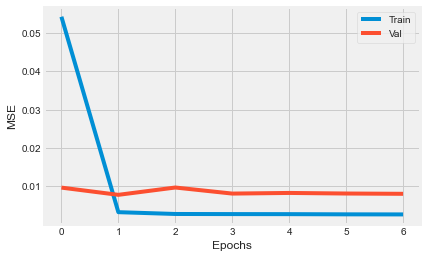

In [33]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

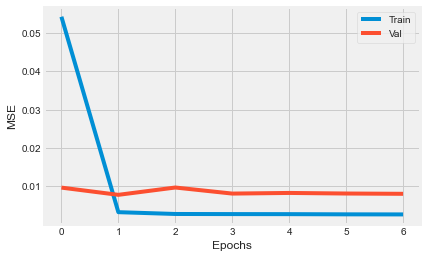

In [34]:
plt.plot(history1.history['mean_squared_error'])
plt.plot(history1.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

## Model 2 Evaluation

In [35]:
y_pred2 = model2.predict(x_test)
y_pred_inv2 = scaler.inverse_transform(y_pred2)

In [36]:
y_pred_inv2.shape

(154, 30)

In [37]:
rmse1 = np.sqrt(np.mean(((y_pred_inv2 -y_test_inv) ** 2)))
print(f'RMSE：{np.round(rmse1, 4)}')

RMSE：5.3819


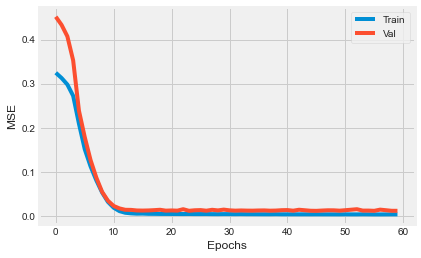

In [38]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

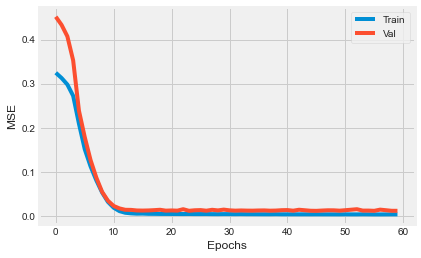

In [39]:
plt.plot(history2.history['mean_squared_error'])
plt.plot(history2.history['val_mean_squared_error'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train','Val']);

In [40]:
train = data[:training_data_len]
test = data[training_data_len+60:]

In [41]:
test.shape

(183, 1)

In [42]:
y_pred_inv2.shape

(154, 30)

In [43]:
last_30=y_pred_inv2[-1]

In [44]:
last_30.shape

(30,)

In [45]:
y_pred_inv2_t= [ t[0]  for t in y_pred_inv2[:-1]]

In [47]:
y_pred_inv2_t=np.array(y_pred_inv2_t)

In [48]:
y_pred_inv2_fin=np.append(y_pred_inv2_t,last_30, axis=0)

In [49]:
len(y_pred_inv2_fin)

183

In [51]:
test['Predictions'] = y_pred_inv2_fin

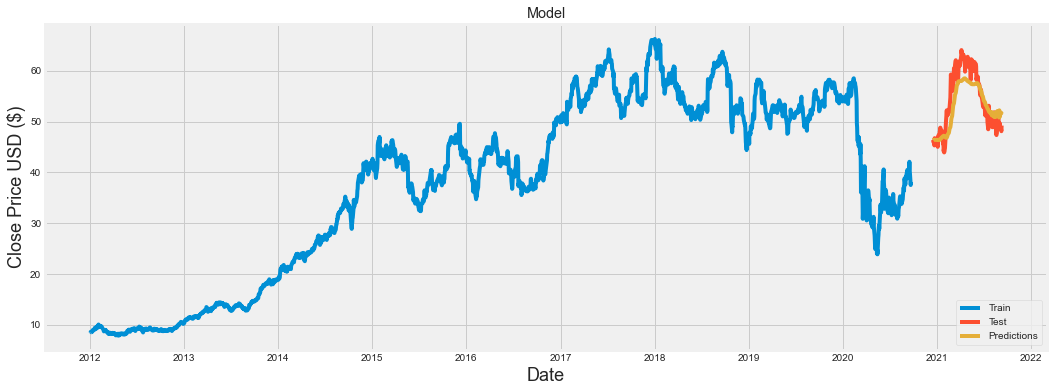

In [52]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [53]:
test

,Close,Predictions
Date,,
2020-12-17,46.389999,46.359566
2020-12-18,46.029999,46.399036
2020-12-21,45.799999,46.423054
2020-12-22,45.320000,46.431061
2020-12-23,46.750000,46.418995
...,...,...
2021-09-02,49.599998,50.955791
2021-09-03,48.860001,51.443905
2021-09-07,48.529999,51.604759
